# OBIA classification
The input data is aerial photo and digital model. The code was taken from [Machinalis blog](http://www.machinalis.com/blog/obia/) and edited for using digital model additionally. In the version of the code gdal is not used and raster data is used instead of vector data. The aerial images from UAV is taken from [FTP server of Mavinci GmbH](ftp://mavinci.de) and edited by me. In the text "#DB" is mean that I changed or add it.

In [1]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
#from osgeo import gdal - is not used
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from PIL import Image #DB

#RASTER_DATA_FILE = "data/image/2298119ene2016recorteTT.tif"
#TRAIN_DATA_PATH = "data/train/"
#TEST_DATA_PATH = "data/test/"

In [2]:
# The module 2 is not used

In [3]:
# Add raster aerial image and convert
raster_dataset = Image.open('ortho.png') #DB
raster_dataset_DM = Image.open('dm.png') #DB
raster_dataset_DM = np.array(raster_dataset_DM) #DB

# 4 = [RGB=3] + [DM=1]
n_bands = 4 #DB

bands_data=np.array(raster_dataset)
bands_data_DM=(np.array(raster_dataset_DM)[:,:,0]).reshape(raster_dataset_DM.shape[0],raster_dataset_DM.shape[1],1)
print bands_data.shape, bands_data_DM.shape

(1538, 1428, 3) (1538, 1428, 1)


In [4]:
# Create images

img = np.c_[bands_data, bands_data_DM] / 255. #DB

# For changing channels, here it is not used
#rgb_img = np.dstack([img[:, :, 3], img[:, :, 2], img[:, :, 1]])
rgb_img=img #DB

print rgb_img.shape #DB

(1538, 1428, 4)


<IPython.core.display.Javascript object>


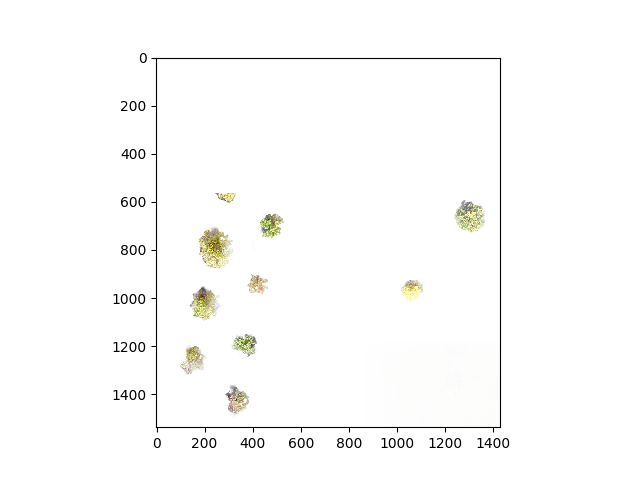

In [5]:
# Plotting

plt.figure()
plt.imshow(rgb_img)

In [ ]:
# Quickshift segmentation

segments_quick = quickshift(rgb_img, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

<IPython.core.display.Javascript object>


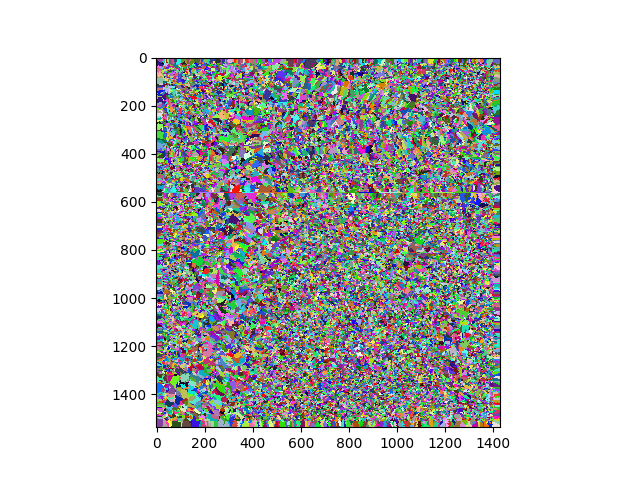

In [7]:
# Plotting Quickshift segmentation

cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

skimage.segmentation.felzenszwalb is not prepared to work with multi-band data. So, based on their own implementation for RGB images, segmentation is applied in each band and then combine the results. See:
http://github.com/scikit-image/scikit-image/blob/v0.12.3/skimage/segmentation/_felzenszwalb.py#L69

In [8]:
# Felzenszwalb segmentation

band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(rgb_img[:, :, i], scale=85, sigma=0.25, min_size=9))

Put pixels in same segment only if in the same segment in all bands. We do this by combining the band segmentation to one number

In [9]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(rgb_img.shape[:2])

<IPython.core.display.Javascript object>


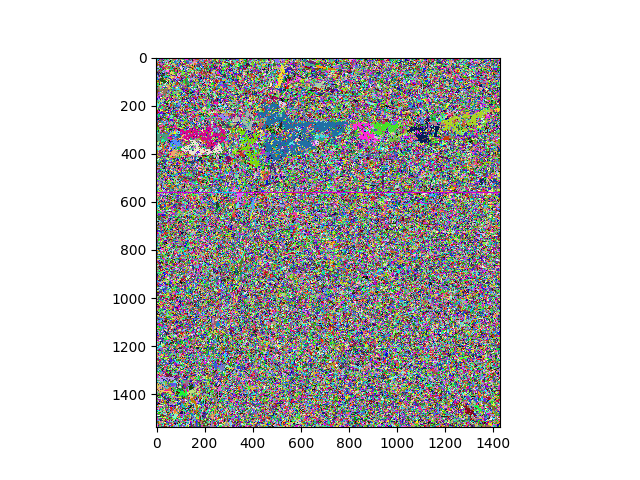

In [10]:
# Plotting Felzenszwalb segmentation

cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()

plt.imshow(segments_felz, interpolation='none', cmap=cmap)

<IPython.core.display.Javascript object>


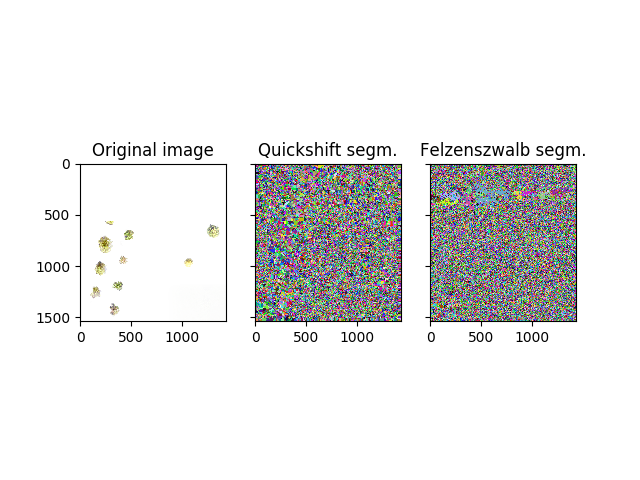

In [11]:
# Plotting two segmentations and original image

n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segm.')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segm.')
plt.show()

In [12]:
# Machinalis chose the felz segmentation
# I chose too because it is more segments and it is smaller 
# that is why I can get better accuracy of classification

segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 230586 segments.


In [19]:
rows, cols, n_bands = rgb_img.shape #DB
print rows, cols, n_bands #DB
print 'Number of pixels is', rows*cols #DB
print 'Felzenszwakb / Pix = ', round(float(len(segment_ids))/rows/cols, 3) #DB
print 'Quickshift / Pix = ', round(float(len(np.unique(segments_quick)))/rows/cols, 3) #DB

classes_labels = ['A','B','C'] #DB

1538 1428 4
Number of pixels is 2196264
Felzenszwakb / Pix =  0.105
Quickshift / Pix =  0.019


(1538, 1428)


<IPython.core.display.Javascript object>


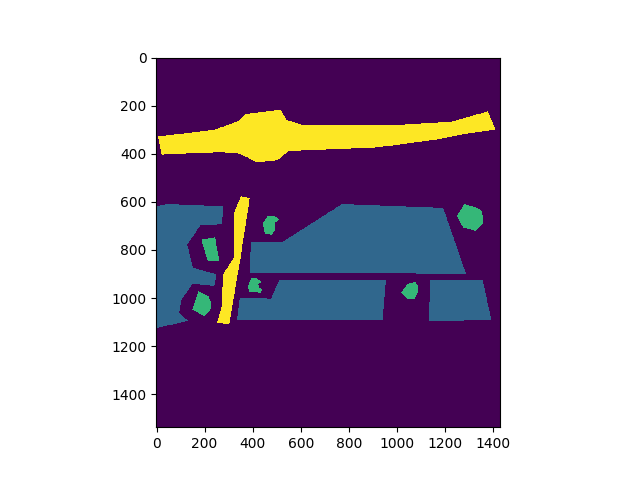

In [20]:
# I use raster data for training. Add it and plot

ground_truth = Image.open('labels_with_shadows.png') #DB 

#"""
ground_truth = np.array(ground_truth)/255. #DB
ground_truth = np.array(ground_truth[:,:,0]+ground_truth[:,:,1]*2+ground_truth[:,:,2]*3) #DB
#"""

ground_truth = np.array(ground_truth) #DB
print np.array(ground_truth).shape #DB
plt.figure()
plt.imshow(ground_truth)
plt.show()

In [21]:
#classes = np.unique(ground_truth)[1:]  # 0 doesn't count
classes=[1,2,3] #DB
len(classes)

3

In [22]:
segments_per_klass = {}
print segments.shape
print ground_truth.shape
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print len(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))
#print segments_of_klass[0] #DB

(1538, 1428)
(1538, 1428)
412303
Training segments for class 1: 45233
28235
Training segments for class 2: 4697
167877
Training segments for class 3: 10233


## Disambiguation
Check if there are segments which contain training pixels of different classes.

In [23]:
accum = set()
intersection = set()
i= 0
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

### ¡No need to disambiguate!

Next, we will _paint in black_ all segments that are not for training.
The training segments will be painted of a color depending on the class.

To do that we'll set as threshold the max segment id (max segments image pixel value). 
Then, to the training segments we'll assign values higher than the threshold.
Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [24]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

### Lets see the training segments

<IPython.core.display.Javascript object>


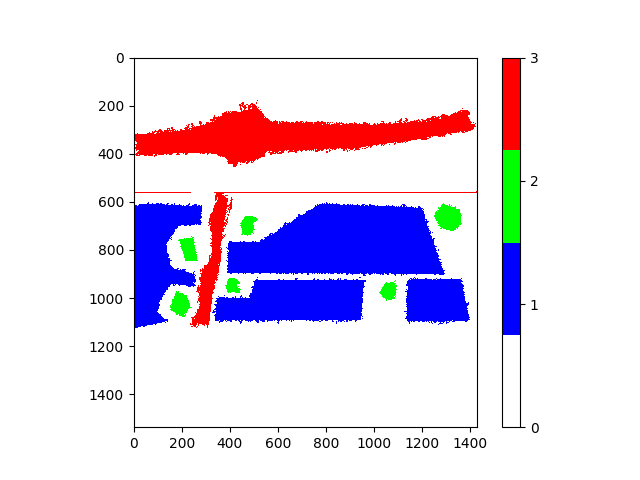

In [25]:
plt.figure()
cm = np.array([[1,1,1], [0,0,1], [0,1,0], [1,0,0]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3])

# Training data

So now, we transform each training segment into a _segment model_ and thus creating the training dataset.

In [26]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features


### Create all the objects: 
compute the features' vector for each segment (and append the segment ID as reference)

In [27]:
# Creating segments
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 230586 objects


### Subset the training data

In [28]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 45233
Training samples for class 2: 4697
Training samples for class 3: 10233


# Train a classifier

In [29]:
classifier = RandomForestClassifier(n_jobs=-1)
#from sklearn.ensemble import BaggingClassifier
#classifier = BaggingClassifier(n_jobs=-1)

In [30]:
classifier.fit(training_objects, training_labels)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

# Classify all segments
Now we have to transform all segments into a _segment models_ in order to classify them

In [31]:
predicted = classifier.predict(objects)

# Propagate the classification
Now that each segment has been classified, we need to propagate that classification to the pixel level. That is, given the class **k** for the segment with label **S**, generate a classification from the segmented image where all pixels in segment **S** are assigned the class **k**.

In [32]:
clf = np.copy(segments)

In [33]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

<IPython.core.display.Javascript object>


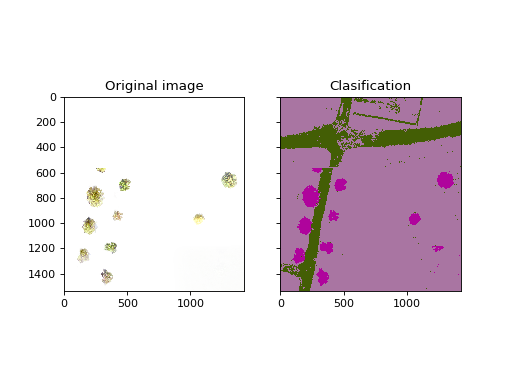

Text(0.5,1,'Clasification')

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
ax2.set_title('Clasification')

In [38]:
# Edit and save the result

print clf.shape[0], clf.max(), clf.min()
obia=np.zeros((1538,1428,3))
for i in range(clf.shape[0]):
    for j in range(clf.shape[1]):
        if clf[i,j] == 3:
            obia[i,j,2] = 255
        if clf[i,j] == 2:
            obia[i,j,1] = 255
        if clf[i,j] == 1:
            obia[i,j,0] = 255
pil_obia = Image.fromarray(np.uint8(obia))
pil_obia.save('OBIA2DM.png')
box = (0,1538-411, 489, 1538)
# old size - 974, 1428
# new size - 411, 489
pil_obia.crop(box).save('OBIA2DM_test.png')

1538 3 1
